# Diffusion Models for CMB signal sampling

We explore applications of Denoising Diffusion Models to separate the true CMB signal from lensing and foreground noise ( dust and synchroton emission ). 

#### Simulate foreground signal (dust and synchroton) using Denoising Diffusion Models. 

Component separation methods can be broadly categorized into two
types: blind methods and non-blind methods. Nonblind methods typically rely on prior knowledge of the
emission characteristics of foregrounds. When faced with unknown or complex foregrounds, such approaches may introduce biases in the
detection of CMB B-modes (Armitage-Caplan et al.
2012; Remazeilles et al. 2016; Hensley & Bull 2018). In
contrast, blind source component separation algorithms
do not rely on prior knowledge of foregrounds. Instead,
they leverage the independent statistical properties of
different components to separate signals.

We start with a non-blind method. But we will try a blind method approach analogous to what is done for the cocktail party problem in the future.

We are interested on training a DM to be able to learn true CMB signal and foreground signals. We use simulated foreground emission data for training, focusing on dust and synchroton emission in particular. For this we use PySM 3, which is explicitly built for full-sky I/Q/U foreground simulations for CMB experiments (bandpasses, beams, HEALPix, Monte Carlos). For the CMB prior we either use a gaussian CMB prior from $C_\ell$ or a simulation-based CMB prior which includes lensing and instruments. We start with a single frequency map at 143 GHz (CMB dominated) for T, Q and U. Can then extend to multi-frequency.

Let y = observed data, x = foreground signal, f = true CMB, n = noise and A = instrumental effects (beam and sky mask) transformation.
We want to sample the posterior $$ P(x,f|y) \sim P(y|x,f)P(x)P(f)$$ To do so we need the priors $P(x)$ and $P(f)$ which will correspond to our training data.

In [25]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import pysm3
import pysm3.units as u
import healpy as hp

import warnings

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### PySM 3

In [27]:
"""
Sky is the main class in PySM 3. It contains the information about the sky model, including the components, the parameters, and the units.
nside (int): The HEALPix resolution parameter.
"""
sky = pysm3.Sky(nside=128, preset_strings=["d1", "s1"]) 
sky.components

sky2 = pysm3.Sky(nside=128, preset_strings=["d1", "s1","c1"]) #c1 is CMB with lensing
sky2.components

In [28]:
"""
get_emission(frequency, **kwargs): Get the emission at a given frequency.
Returns 2D array of shape (3, nside, nside) in healpy convention.

map_100GHz.shape = (3, 12*128*128)
The number 12 is the foundation of the HEALPix geometry. 
At the lowest possible resolution (NSIDE = 1), the sphere is divided into 12 base pixels.
Each base pixel is then subdivided into 4 child pixels at the next resolution level (NSIDE = 2), and so on.
"""

map_100GHz = sky.get_emission(100 * u.GHz)
map_100GHz[:,0] # returns [I, Q, U] for first base pixel

map_100GHz2 = sky2.get_emission(100 * u.GHz)
map_100GHz2[:,0] # returns [I, Q, U] for first base pixel





<Quantity [-42.50500048,   1.73418991,   1.24725415] uK_RJ>

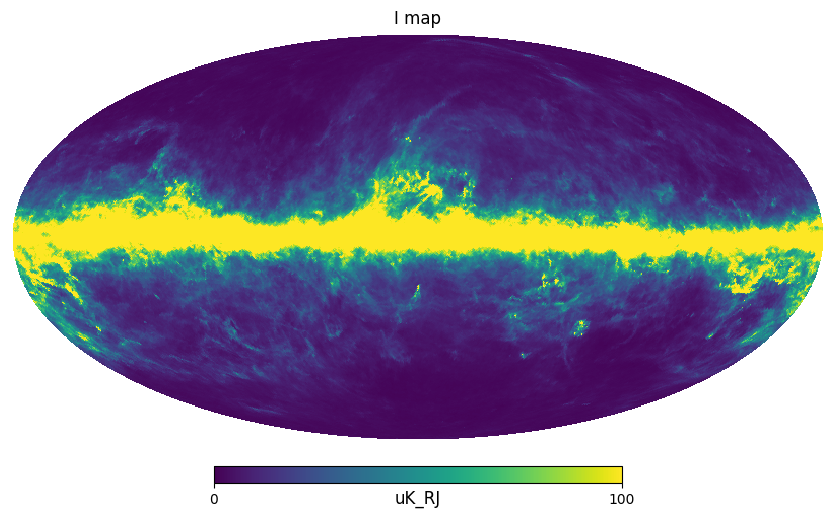

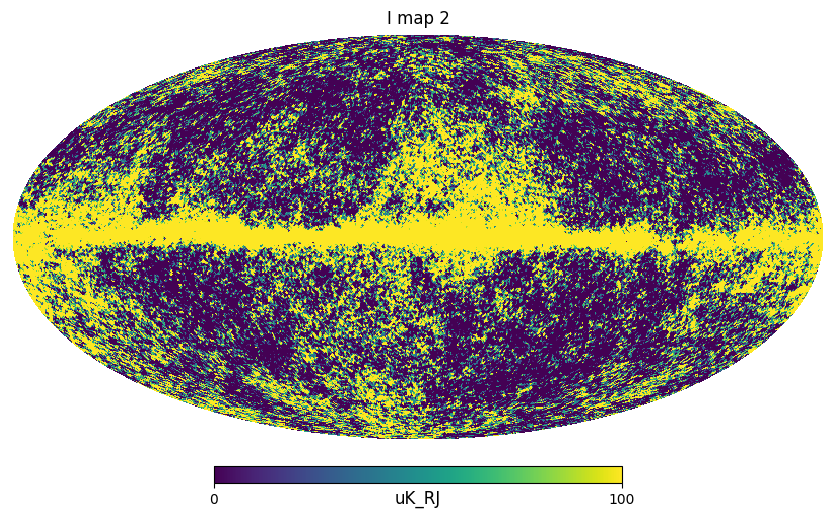

In [29]:
hp.mollview(map_100GHz[0], min=0, max=1e2, title="I map", unit=map_100GHz.unit)
hp.mollview(map_100GHz2[0], min=0, max=1e2, title="I map 2", unit=map_100GHz.unit)



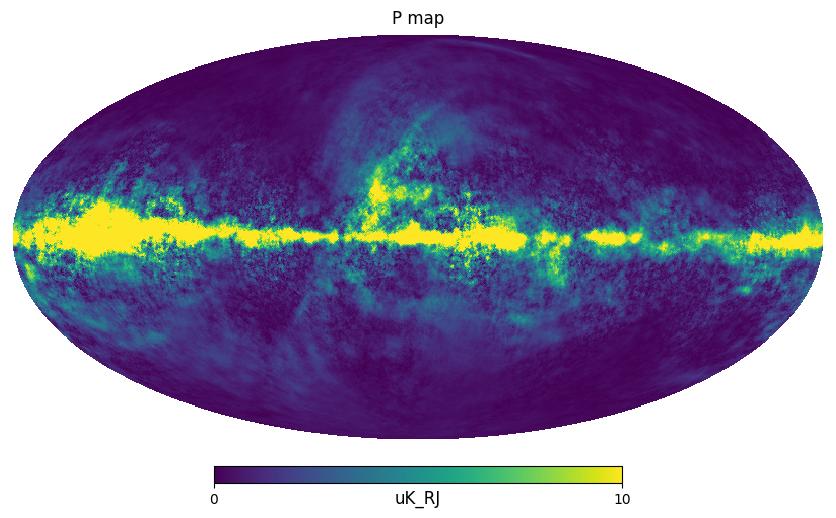

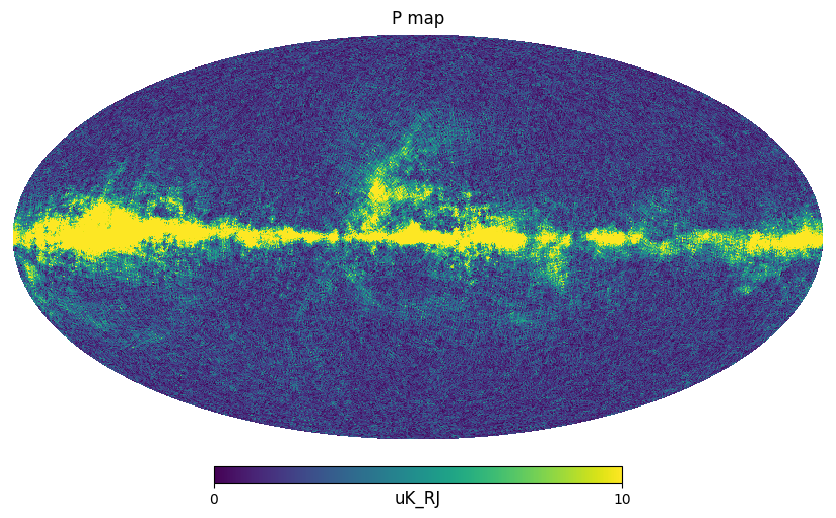

In [30]:
hp.mollview(np.sqrt(map_100GHz[1]**2 + map_100GHz[2]**2), title="P map", min=0, max=1e1, unit=map_100GHz.unit)
hp.mollview(np.sqrt(map_100GHz2[1]**2 + map_100GHz2[2]**2), title="P map", min=0, max=1e1, unit=map_100GHz.unit)


#### Plank Data

We use single frequency 143 GHz half ring data plus masking data from PR4.

In [ ]:
### Import data

hr1_path = "/Users/davideprovasoli/Desktop/Diffusion Models/cmb_data/hr1_143.fits"
hr2_path = "/Users/davideprovasoli/Desktop/Diffusion Models/cmb_data/hr2_143.fits"
mask_path = "/Users/davideprovasoli/Desktop/Diffusion Models/cmb_data/mask_143.fits"

hr1 = hp.read_map(hr1_path, field=(0,1,2))
hr2 = hp.read_map(hr2_path, field=(0,1,2))
mask = hp.read_map(mask_path)



In [ ]:
### Checks

print("nside hr:", hp.get_nside(hr1[0]), hp.get_nside(hr2[0]))
print("nside mask:", hp.get_nside(mask))
print("mask range:", np.nanmin(mask), np.nanmax(mask))

nside hr: 2048 2048
nside mask: 2048
mask range: 0.0 1.0


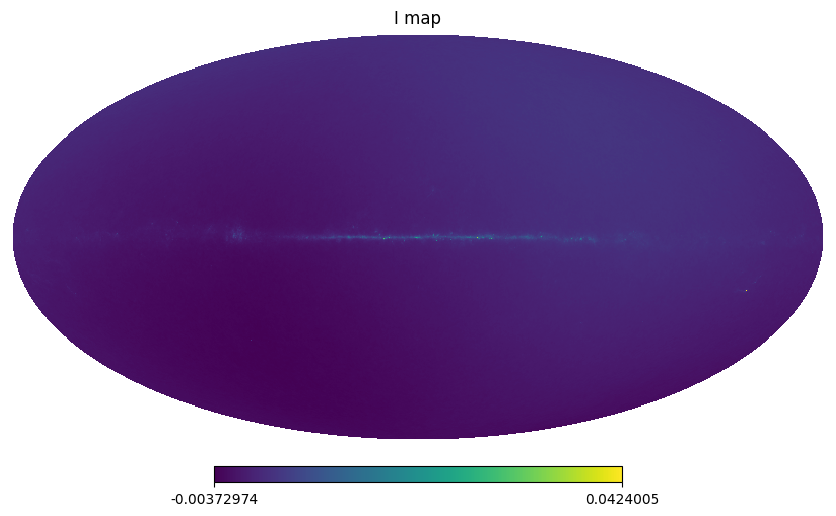

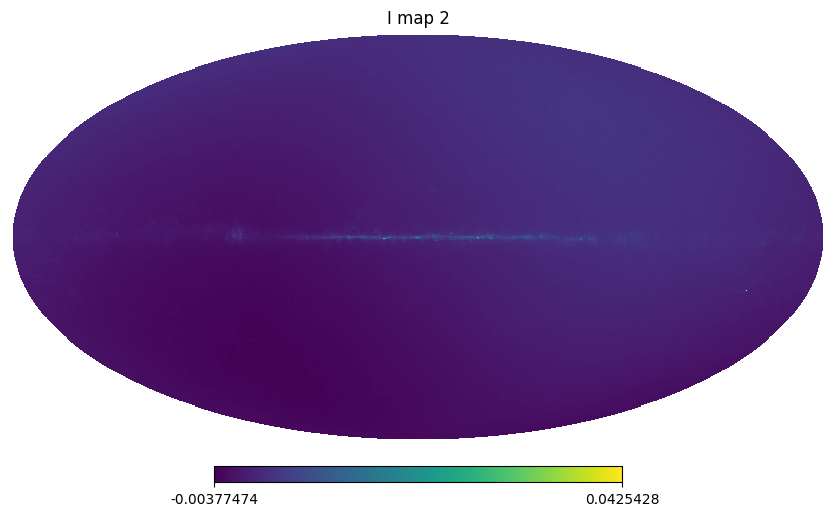

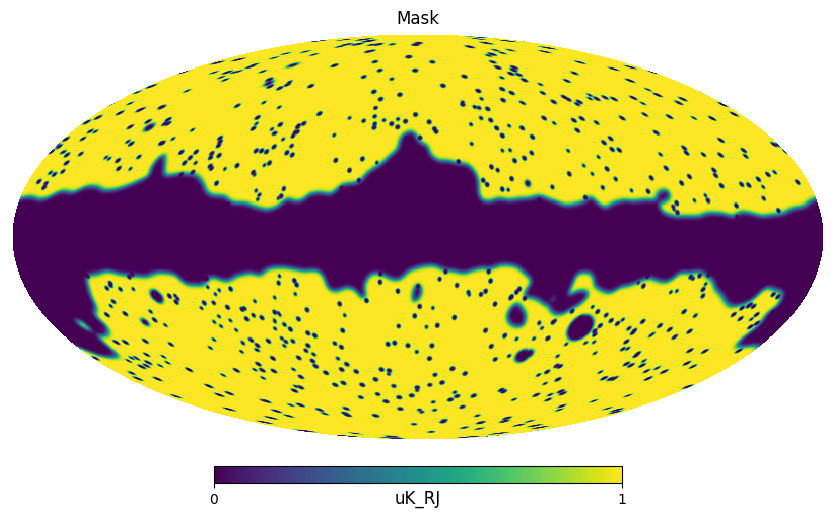

In [38]:
### Plot

hp.mollview(hr1[0], title="I map")
hp.mollview(hr2[0], title="I map 2")
hp.mollview(mask, min=0, max=1, title="Mask", unit=map_100GHz.unit)

